In [ ]:
# Importing necessary libraries
from google.colab import drive
import os
import json
import multiprocessing as mp
from multiprocessing import Pool
from time import time
from datetime import timedelta
import nltk
nltk.download('all')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import random
import re
from typing import Dict, List
from tqdm import tqdm
import pickle as pk
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
import warnings
warnings.filterwarnings("ignore")

stop_words = set(stopwords.words('english'))

First, we need to create another corpus with only abstracts from the covid-19 papers.

Note that this time, we need all the abstracts as separate, which is different from the earlier cases where we just concatenated all the abstracts in the same file.

In [ ]:
# Mount the drive on colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzipping all the files
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/pdf_json.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/NLP_corpus/')

In [ ]:
# Considering only the JSON files
files = os.listdir('/content/NLP_corpus/pdf_json')
files = [x for x in files if x.endswith('.json')]
print(len(files))

56528


In [ ]:
# Path of all json files
Sroot = "/content/NLP_corpus/pdf_json"

In [ ]:
def json2text(filename):
  '''
  Preprocesses each file and returns (file_name, preprocessed_text)
  '''

  with open(os.path.join(Sroot, filename), 'r') as file:
    content = file.read()
    paper_content = json.loads(content)

    abstract = []


    if 'abstract' in paper_content:
        for c in paper_content['abstract']:

          total_text = c['text']

          # Preprocessing

          # Removing html links
          pattern = r'http[s]?://\S+'
          total_text = re.sub(pattern, '', total_text)

          # Removing extra characters (not all, like - or :, etc.)
          pattern = r'[)(,.{}[\]<>?\/!@#$%^&*`~\'";=]'
          total_text = re.sub(pattern, '', total_text)

          # Removing numbers occuring as stand-alone words
          # Not all numbers, like in Covid-19
          words = word_tokenize(total_text)
          words = [word.lower() for word in words if word.isdigit() == False]

          # Finally, the stopwords
          words = [word for word in words if word not in stop_words]

          total_text = ' '.join(words)
          abstract.append(total_text)

    return (filename[:-5], abstract)

In [ ]:
def par_write(files):
  '''
  Uses multiprocessing to map the function json2text on all files, and saves the complete preprocessed abstract corpus in a json file.
  '''
  start = time()

  total_files = len(files)

  progress = tqdm(total=total_files, desc="Processing Files")

  def update_progress(result):
      progress.update()

  with Pool() as p:
      results = []
      for file in files:
          res = p.apply_async(json2text, args=(file,), callback=update_progress)
          results.append(res)

      p.close()
      p.join()

  print(f"\nExtraction complete. Time taken = {timedelta(seconds = time() - start)}\n")

  result_dict = {f"{res.get()[0]}_{t}": res.get()[1][t] for res in results for t in range(len(res.get()[1])) if res.get()[1] != []}

  print("Dictionary conversion complete")

  # Save the results to a JSON file
  with open('/content/drive/MyDrive/abstract_corpus.json', 'w') as f:
      json.dump(result_dict, f)

  print("Saving abstract_corpus.json complete")

In [ ]:
par_write(files)

Processing Files: 100%|█████████▉| 56513/56528 [02:57<00:00, 407.79it/s]


Extraction complete. Time taken = 0:02:57.311889

Dictionary conversion complete



Processing Files: 100%|██████████| 56528/56528 [02:58<00:00, 316.46it/s]

Saving abstract_corpus.json complete


In [ ]:
with open('/content/drive/MyDrive/abstract_corpus.json', 'r') as f:
  content = f.read()
  json_content = json.loads(content)

In [ ]:
print(f"Type of file = {type(json_content)}")
print(f"Length of file = {len(json_content)}")

Type of file = <class 'dict'>
Length of file = 78470


Thus, we have around 78,470 abstracts in total.

Now, we are ready to make the sequential model on the abstract data.

100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 2229589.62it/s]


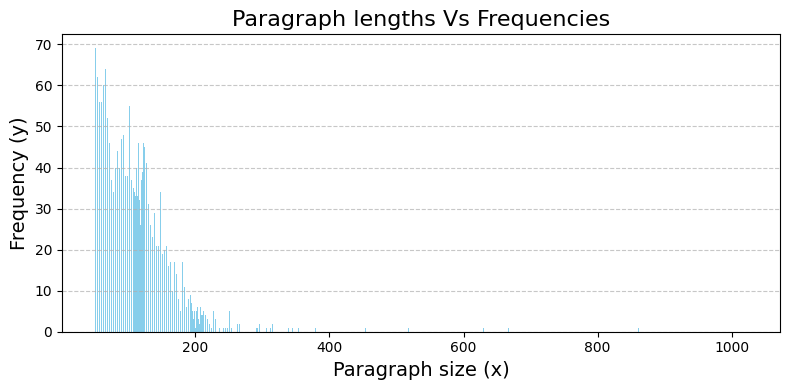

In [ ]:
# Smaller corpus for faster training
larger_paragraphs = [x for x in list(json_content.values()) if len(x.split()) >= 50] # Selecting only large paragraphs
smaller_data = random.sample(larger_paragraphs, 5000)

# Tokenization
tokenized_paragraphs = [para.lower().split() for para in smaller_data]

size_dict = dict()
for x in tqdm(tokenized_paragraphs):
    t = len(x)
    if t not in size_dict:
        size_dict[t] = 1
    else:
        size_dict[t] += 1

len_vs_freq = sorted(list(size_dict.items()), key = lambda x: x[0])
x = [a[0] for a in len_vs_freq]
y = [a[1] for a in len_vs_freq]

# Plotting the bar chart
plt.figure(figsize=(8, 4))
plt.bar(x, y, color='skyblue', width = 0.6)
plt.title('Paragraph lengths Vs Frequencies', fontsize=16)
plt.xlabel('Paragraph size (x)', fontsize=14)
plt.ylabel('Frequency (y)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show();

Looks like there are hardly paragraphs with size more than 200. Thus, we can safely clip all the paragraphs upto length of 256. This should reduce the unrolling steps for the lstm layer, thereby reducing the memory and time required for training, as well as not loosing any significant information from the data.

In [ ]:
# Count word frequencies
counter = Counter(word for para in tokenized_paragraphs for word in para)

# Define special tokens
special_tokens = ["<unk>", "<pad>", "<end>"]

# Build vocabulary
vocab = {token: idx for idx, token in enumerate(special_tokens)}
for word, _ in counter.most_common():
    if word not in vocab:
        vocab[word] = len(vocab)

# Reverse mapping for decoding
vocab_reverse = {idx: token for token, idx in vocab.items()}

# Function to encode paragraphs with the <end> token
def encode_paragraph(paragraph, vocab):
    return [vocab.get(word, vocab["<unk>"]) for word in paragraph][:256]  # We truncate every paragraph to maximum of 256 tokens

encoded_paragraphs = [encode_paragraph(para, vocab) + [vocab["<end>"]] for para in tokenized_paragraphs]

In [ ]:
# Convert to tensors and then padding (all paragraphs to same length)
def pad_sequences(encoded_paragraphs, padding_value):
    sequences = [torch.tensor(seq) for seq in encoded_paragraphs]
    return pad_sequence(sequences, batch_first=True, padding_value=padding_value)

padded_paragraphs = pad_sequences(encoded_paragraphs, vocab["<pad>"])

In [ ]:
# Create input and output pairs
data = []
for para in padded_paragraphs:
    input_seq = para[:-1]
    target_seq = para[1:]
    data.append((input_seq, target_seq))

In [ ]:
# DataLoader
dataloader = DataLoader(data, batch_size=8, shuffle=True)

In [ ]:
class LSTMTextModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers = 2):
        super(LSTMTextModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        # Stacked LSTM layers (2 layers)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)
        # LSTM layers
        x, _ = self.lstm(x)
        # Output layer (probability distribution over vocabulary)
        x = self.fc(x)
        return x

The model above consists of:

1) Embedding layer: Takes in input tokens and maps them to smaller dimensional vectors (embed_size)

2) LSTM Layer: A 2 layer lstm block that predicts the output of every word from the words in input.

3) Output Layer: Gives the probability distribution of next word over the vocabulary

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Hyperparameters
vocab_size = len(vocab)
embed_size = 256
hidden_size = 256

# Model, Loss, Optimizer
model = LSTMTextModel(vocab_size, embed_size, hidden_size)
model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Model Training
epochs = 30
losses = []
for epoch in range(1, epochs + 1):
    print(f'Training epoch {epoch}')
    model.train()
    epoch_loss = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        outputs = outputs.view(-1, vocab_size)
        targets = targets.view(-1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch}/{epochs} | batch {batch_idx + 1}/{len(dataloader)}, Loss : {loss.item()}")
    losses.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

    # Saving model after every epoch (to prevent loosing the model while compilation error)
    with open('the_model.pickle', 'wb') as f:
        pk.dump(model, f)

Training epoch 1
Epoch 1/30 | batch 100/625, Loss : 8.70396900177002
Epoch 1/30 | batch 200/625, Loss : 9.063349723815918
Epoch 1/30 | batch 300/625, Loss : 8.692378044128418
Epoch 1/30 | batch 400/625, Loss : 7.994418144226074
Epoch 1/30 | batch 500/625, Loss : 9.099491119384766
Epoch 1/30 | batch 600/625, Loss : 8.617513656616211
Epoch 1/30, Loss: 8.6985
Training epoch 2
Epoch 2/30 | batch 100/625, Loss : 8.648392677307129
Epoch 2/30 | batch 200/625, Loss : 7.792375564575195
Epoch 2/30 | batch 300/625, Loss : 8.015898704528809
Epoch 2/30 | batch 400/625, Loss : 8.204852104187012
Epoch 2/30 | batch 500/625, Loss : 7.983089447021484
Epoch 2/30 | batch 600/625, Loss : 7.7900309562683105
Epoch 2/30, Loss: 7.9636
Training epoch 3
Epoch 3/30 | batch 100/625, Loss : 7.394314289093018
Epoch 3/30 | batch 200/625, Loss : 7.184576511383057
Epoch 3/30 | batch 300/625, Loss : 7.654853343963623
Epoch 3/30 | batch 400/625, Loss : 7.642049312591553
Epoch 3/30 | batch 500/625, Loss : 7.25588512420654

### Loss Vs Epoch Plot

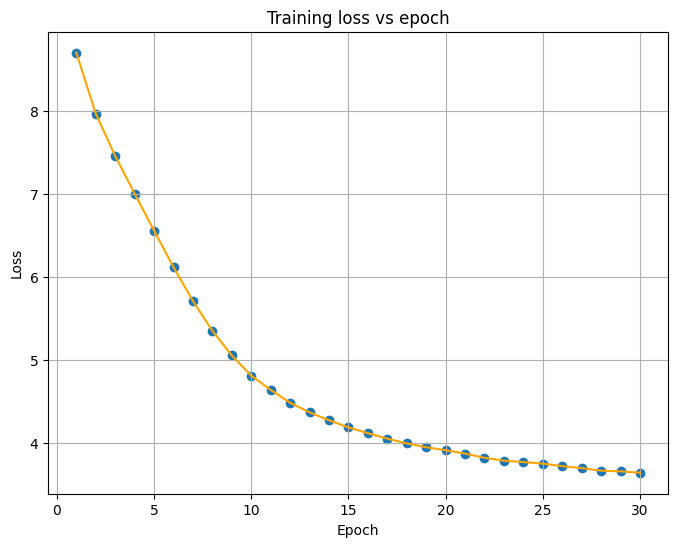

In [ ]:
# Plot Training loss vs Epoch
x = list(range(1, len(losses) + 1))

plt.figure(figsize=(8, 6))
plt.scatter(x, losses, label="Points")
plt.plot(x, losses, label="Line", linestyle='-', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss vs epoch')
plt.grid()
plt.show();

We have a decreasing loss over the epoch plot. This strongly suggests that our model has learned the contextual dependencies from the given data.

In [ ]:
# Moving the model to cpu after completely training the model
model = model.to('cpu')

In [ ]:
def predict(model, input_seq, vocab, max_len=50):
    model.eval()
    input_seq = torch.tensor(input_seq).unsqueeze(0)
    predictions = []

    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_seq)
            next_word = torch.argmax(output[:, -1, :], dim=-1).item()
            if next_word == vocab["<end>"]:  # Early stopping when <end> token is predicted
                break
            predictions.append(next_word)
            input_seq = torch.cat([input_seq, torch.tensor([[next_word]])], dim=1)  # Auto-regressive step

    return [vocab_reverse[idx] for idx in predictions]

### Predicted abstracts from three randomly generated samples from the dataset

In [ ]:
input_text = random.sample(smaller_data, 1)[0]
input_seq = [vocab[word] for word in input_text.split()][:10]
predicted_words = predict(model, input_seq, vocab)
print(f"Predicted text - \f")
print(" ".join(input_text.split()[:10]), end = " ")
print(" ".join(predicted_words))

Predicted text - 

background : large cohorts span entire population raise new prospects developing countries quickly vulnerable populations important element tremendous urgency accommodate citizens prevent spread covid-19 seems linked uncontrolled reach epidemic growth epidemic well epidemic curves epidemic hotspot epidemic spread infection shortest new epidemic spread in-out flow epidemic intelligence ai algorithms epidemic estimates r0 epidemic solely parameter theoretically broadly isolating worst-case scenarios


In [ ]:
input_text = random.sample(smaller_data, 1)[0]
input_seq = [vocab[word] for word in input_text.split()][:10]
predicted_words = predict(model, input_seq, vocab)
print(f"Predicted text - \f")
print(" ".join(input_text.split()[:10]), end = " ")
print(" ".join(predicted_words))

Predicted text - 

cyclic amp receptor protein crp also known catabolite activator protein synthesis protein compact corresponding c-terminal domain unfolded n-terminal fusions folding trafficking mutated c-terminal domain unfolded n-terminal domain ntd lectins quantify b af orf1 mutated domain relatively rigid several hitherto unlike escherichia coli salmonella typhimurium x3987 pyats-1 andx3987 pyats-4 expressing constitutively kda amino-terminal fragment resulted preferential binding cues anti-herbivore accumulation degradation


In [ ]:
input_text = random.sample(smaller_data, 1)[0]
input_seq = [vocab[word] for word in input_text.split()][:10]
predicted_words = predict(model, input_seq, vocab)
print(f"Predicted text - \f")
print(" ".join(input_text.split()[:10]), end = " ")
print(" ".join(predicted_words))

Predicted text - 

simple summary : animals countless species wild well tame entertain tourists holidays popularity however animal-based constituents counter nature conservation endangered species freshwater ecosystems visualize fluorescently-labeled word count : authorfunder los factores sorgen h c ha sottolineato la necessità di un nuovo punto di arrivo son outer un punto di arrivo uncommon : 6volutives nucleico fue il decadimento delle les facteurs


### Discussion over the results

We note that the generated texts above are, although sensible, does not makes sense in the long run (as an overall paragraph). We can list down the three major problems here.

#### Problem 1

The phrases in generated paragraph locally makes sense, but fail to capture the overall meaning.

Possible Remedy: This suggests that the model is able to capture the local meaning of words very efficiently, but is failing to capture the overall meaning of the paragraph. This can be tackled by increasing the size of embedding layers, hidden layers, or the number of LSTM layers (higher than 2).

#### Problem 2

Words tend to repeat in the generated paragraph.

Possible Remedy: This suggests that the model is not focussing on far-away information, leading to information forgetting. This might be tackled by increasing lstm layers and making residual connections.

#### Problem 3

The above remedies tend to increase the training time and complexity.

Possible Remedy: We might need to increase the training dataset for the model (from 5000 to 10,000 or higher). Also, we can increase the number of words we provide to the model initially (10 in our case). This might increase the overall sense of generated paragraphs.